#__CS345 Project by: Wyatt Markham and AJ Leichner__

## __Model Predicting Comparison Between Various Steam Data Points and Game Metacritic Score__

The purpose of this layered Support Vector Machine (SVM) model implementation is to predict the Game Metacritic Score (GMS) for various Steam-platformed games based on a variety of features listed below. The objective is to make accurate Matacritic Score predictions based on these features and their correlation to the GMS.

> _Features:_
> * North American Sales
> * European Sales
> * Japanese Sales
> * Other Sales
> * Global Sales
> * Critic Count
> * User Score
> * User Count


###Dataset

The data for this model comes from https://data.world/mhoangvslev/steam-games-dataset/workspace/file?filename=vgsales.csv which is a data set that contains data on the sales and user and critic scores for a subset of games on steam.

####Importing Necessary Libraries:

In [ ]:
import chardet
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.model_selection import GridSearchCV
import pandas as pd
import collections
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier

####Reading in the CSV datafile

In [ ]:
#Reads in a CSV
with open("steam-games.csv", "rb") as f:
    encoding = chardet.detect(f.read())["encoding"]
with open("steam-games.csv", "r", encoding=encoding) as f:
    totalData = list(csv.reader(f))

In [ ]:
X = []
y = []
yRaw = []
columnLables = totalData[0]
useableData = totalData[1:]
for row in useableData :
        X.append([float(row[i]) if i in {1,2,3,4,5,7}
                  else int(row[i])
                  for i in range(1,len(useableData[0]))])
        label = int(row[0])
        yRaw.append(label)
        if (label <= 70) :
          label = 0
        else :
          label = 1
        y.append(label)


##The features
* X[:][0] NA Sales
* X[:][1] EU Sales
* X[:][2] JP Sales
* X[:][3] Other Sales
* X[:][4] Global Sales
* X[:][5] Critic count
* X[:][6] User score
* X[:][7] User count

##The Labels
* 0 all games with a critic score under 70
* 1 all games with a critic score over 70

##Why these Features and Labels
We chose these features because in the data set that we are using these are the only features with numerical data other than the date of release. While it could be possible to convert text data into numerical data it would require arbitrary choices for the data. For example, one feature we considered was to include the maturity rating of the games. We would give each maturity rating a numerical value like E would be 0 and M would be 2 but that would be completely arbitrary and wouldn't accurately represent the data. For the labels, we went through many iterations. Intially we had 10 labels where the critic score was either 1 to 10 and those would be the labels. However, that resulted in abysmal accuracy (25%). Then we decided to try a regression but once again the accuracy was really bad. So we ended up trying to split the data into 2 labels which resulted in the best accuracy we had been able to achieve at that point. The number 70 came from the process below.


In [ ]:
def avarages(data) :
  for i in range(len(data[0])):
    curr = 0
    for game in data :
      curr += game[i]
    print(i,curr/len(data))
avarages(X)

0 0.3909196402669175
1 0.23451697127936025
2 0.06386713083840923
3 0.08200029010733266
4 0.7714868001160579
5 28.842471714534376
6 7.184377719756343
7 174.39237017696547


This shows the average values of every feature to help us visualize the data and make insights. Like what features we should try to remove to get better accuracy. But whenever we tried to remove any feature from the data set the accuracy would go down significantly so none of the original features were removed.

#Finding the right split for the data
To find the split of the data that would allow for 50% of the games to be classified as one label and 50% to be classified as the other we used the below program to figure out the distribution of the labels. We changed the split point until we saw that both bars were roughly at the same height. And that is how we got 70 to be the split point for the labels.


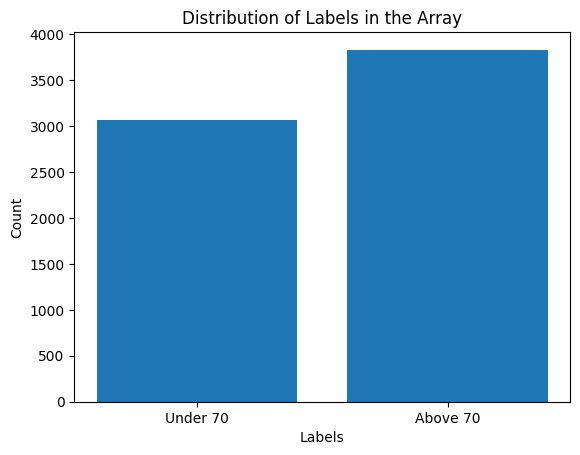

In [ ]:
num1 = 0
num2 = 0
for num in y:
  if num == 0:
    num1+=1
  elif num == 1:
    num2+=1
values = [num1,num2]
# Create a bar chart
fig, ax = plt.subplots()
# Get the keys (labels) and values (counts) for plotting
keys = list(["Under 70","Above 70"])

# Plot the bar chart
ax.bar(keys, values)

# Labeling the chart
ax.set_xlabel("Labels")
ax.set_ylabel("Count")
ax.set_title("Distribution of Labels in the Array")

# Display the chart
plt.show()

#Testing the Model for the first time
For the first run of the model, we decided to do a scaler transform of the data so that all points of data would be between 0 and 1 which can help prevent the data from being biased by individual data points. By standardizing the feature scores to a range between [0, 1], we are reducing data skew.

We chose to run the model with the default hyperparameters to see what the default SVM model will evaluate as. We then run two accuracy tests: an accuracy test for the test data and an accuracy test using cross-validation, which gives us an idea of the average accuracy of the model. We also create a confusion matrix to show us what the model is misclassifying. This can tell us if the model is trying to classifiy one class more than another.
## Why SVM
We chose to use an SVM model because of its realitive ease of use while still having many hyperparameters to choose from. That way we can set up the model and use the default hyperparameters from the start to see a baseline and then be able to gain accuracy from selected better hyperparameters. Also our data set is rather small only about 7,000 points of data. And SVM's tend to do well for data sets that have less data.


In [ ]:
scaler = StandardScaler()

X = scaler.fit_transform(X)
print(X.shape)
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(
    X[:, :], y, test_size=0.2, random_state=5)
svmClass = svm.SVC()
accuracy = cross_val_score(svmClass, X, y, cv=5, scoring='accuracy')
svmClass.fit(X_train, y_train)
pred_y = svmClass.predict(X_test)
conf_matrix = confusion_matrix(y_test, pred_y)
print("STD: ", np.std(accuracy),"Average: ", np.average(accuracy))
print(np.mean(y_test == svmClass.predict(X_test)))

(6894, 8)
STD:  0.05641782239981013 Average:  0.6966854044337044
0.7621464829586657


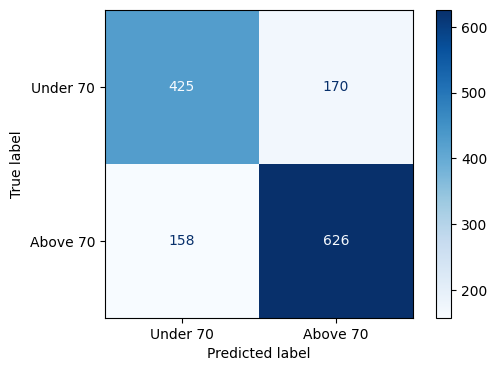

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=keys)
fig, ax = plt.subplots(figsize=(6,4))
disp.plot(ax=ax, include_values=True, cmap=plt.cm.Blues);

#Optimizing the model.
After running the model without any hyperparamaters the accuracy was slightly subpar so we decided to do a grid search to find the best hyperparameters for the model. We chose to evaluate every reasonable kernal and decision function shape as well as a wide variety of c values and degree values in case poly was the best kernal.

In [ ]:
svModel = svm.SVC()
#parameters = {'C':[1,2,3,4,5,6,7,8,9,10], 'kernel':('linear', 'poly','rbf','sigmoid'), 'decision_function_shape': ['ovo', 'ovr'], 'degree':[1,2,3,4]}
#parameters = {'C':[5.5,5.6,5.7,5.8,5.9,6,6.1,6.2,6.3,6.4,6.5], 'kernel':['poly'], 'degree':[1]}
parameters = {'C':[8,9,10,11,12,13], 'kernel':['linear']}
subset_X_train = X_train[:1000]
subset_y_train = y_train[:1000]
grid = GridSearchCV(svModel, parameters)
grid.fit(subset_X_train, subset_y_train)
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.023934,0.001650,0.002393,0.000072,8,linear,"{'C': 8, 'kernel': 'linear'}",0.775,0.83,0.755,0.74,0.74,0.768,0.033556,1
1,0.027460,0.004124,0.002427,0.000085,9,linear,"{'C': 9, 'kernel': 'linear'}",0.775,0.83,0.755,0.74,0.74,0.768,0.033556,1
2,0.024208,0.000948,0.002443,0.000088,10,linear,"{'C': 10, 'kernel': 'linear'}",0.775,0.83,0.755,0.74,0.74,0.768,0.033556,1
3,0.025567,0.001509,0.002326,0.000070,11,linear,"{'C': 11, 'kernel': 'linear'}",0.775,0.83,0.755,0.74,0.74,0.768,0.033556,1
4,0.029536,0.003821,0.002463,0.000041,12,linear,"{'C': 12, 'kernel': 'linear'}",0.775,0.83,0.755,0.74,0.74,0.768,0.033556,1
5,0.032072,0.003484,0.002451,0.000112,13,linear,"{'C': 13, 'kernel': 'linear'}",0.775,0.83,0.755,0.74,0.74,0.768,0.033556,1


#Trying the model with better hyperparmaters
The result of the grid search was that a C value of 8 and a linear kernal using OVR were the best hyperparameters

STD:  0.056679298890329154 Average:  0.7127917097747574
0.7432922407541697


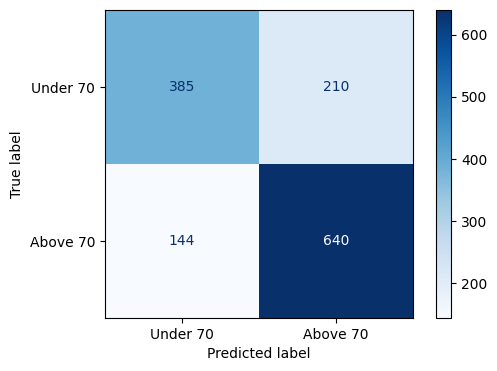

In [ ]:
svmClass = svm.SVC(C=8, kernel = 'linear')
accuracy = cross_val_score(svmClass, X, y, cv=5, scoring='accuracy')
svmClass.fit(X_train, y_train)
pred_y = svmClass.predict(X_test)
conf_matrix = confusion_matrix(y_test, pred_y)
print("STD: ", np.std(accuracy),"Average: ", np.average(accuracy))
print(np.mean(y_test == svmClass.predict(X_test)))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=keys)
fig, ax = plt.subplots(figsize=(6,4))
disp.plot(ax=ax, include_values=True, cmap=plt.cm.Blues);

Through choosing the best hyperparameters we were able to get an almost 2% increase in our accuracy.

#Transforming the data
After finding the best hyperparameters for the data we decided to try and transform our data using multiple differnt methods. Hoping to find a way to increase our accuracy.

##Trying PCA
PCA is a method of transforming features to have the highest variance linear combination of the data you are using. This means it can help remove noise and take only the data points that have some degree of variation meaning fewer redundant points of data. We decided to use PCA because SVMs are very susceptible to noise. So we wanted to have a method that could help trim the noise in the data.  
<br/><br/>
                                           
We first started PCA by trying to find the best number of PCA components for our data. Since PCA components are ranked by variance you want to take the first few PCA components because they will have the highest variance however if a data set is very variant it might be better to include all PCA components.


Best number of componets for PCA is:  1


Text(0.5, 1.0, 'PCA Components vs Accuracy')

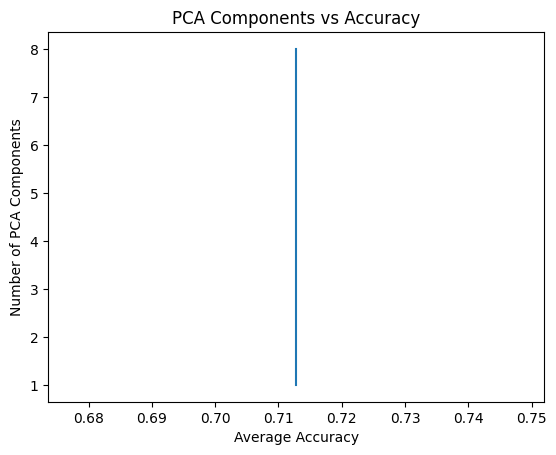

In [ ]:
num_componets = [1,2,3,4,5,6,7,8]
best_num = 0
best_average = 0
averages = []
for num in num_componets :
  pca = PCA(n_components=num)
  X_pca = pca.fit_transform(X)
  X_train, X_test, y_train, y_test = train_test_split(
      X_pca, y, test_size=0.2, random_state=5)
  svmClass = svm.SVC(C=8, kernel = 'linear')
  accuracy = cross_val_score(svmClass, X, y, cv=5, scoring='accuracy')
  svmClass.fit(X_train, y_train)
  pred_y = svmClass.predict(X_test)
  average = np.average(accuracy)
  averages.append(average)
  if (average > best_average) :
    best_average = average
    best_num = num

print("Best number of componets for PCA is: ", best_num)
plt.plot(averages, num_componets)
plt.ylabel('Number of PCA Components')
plt.xlabel('Average Accuracy')
plt.title('PCA Components vs Accuracy')

STD:  0.056679298890329154 Average:  0.7127917097747574
0.6649746192893401


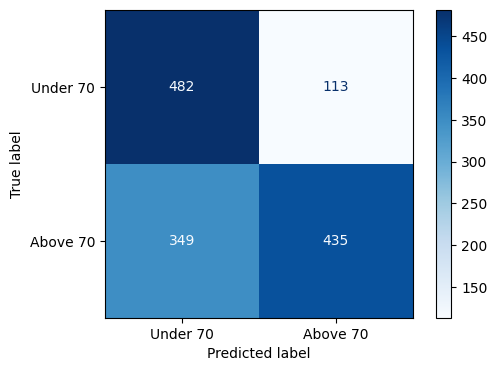

In [ ]:
pca = PCA(n_components=1)
X_pca = pca.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
      X_pca, y, test_size=0.2, random_state=5)

#svmClass = svm.SVC(C=3, kernel = 'poly', degree=1)
svmClass = svm.SVC(C=8, kernel = 'linear')
accuracy = cross_val_score(svmClass, X, y, cv=5, scoring='accuracy')
svmClass.fit(X_train, y_train)
pred_y = svmClass.predict(X_test)
conf_matrix = confusion_matrix(y_test, pred_y)
print("STD: ", np.std(accuracy),"Average: ", np.average(accuracy))
print(np.mean(y_test == svmClass.predict(X_test)))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=keys)
fig, ax = plt.subplots(figsize=(6,4))
disp.plot(ax=ax, include_values=True, cmap=plt.cm.Blues);

###Conclusion on PCA
So at this point 0.7127917097747574% is the best average accuracy that the model can get to. While PCA my have gotten worse accuracy for the test set it got much better average accuracy and since PCA dosen't take to much time our final model may use PCA because it is able to achive the highest accuracy we have been able to get so far.

##Trying TSNE
TSNE is a method similar to PCA but what TSNE does is create a way to visualize the data in 2 or 3 dimensions. This method can help with allowing the SVM to better classify the data because it makes the data less spatially complex which can help. That is why we are evaluating the model on it. However, here our primary reason for using TSNE is to help visualize our data in a 2 dimensional graph. This can help us see what the model may be misclassifying or potential outlier data that is messing with our accuracy.


STD:  0.056679298890329154 Average:  0.7127917097747574
0.7215373459028281


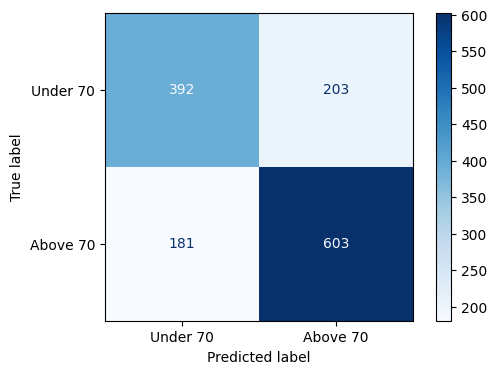

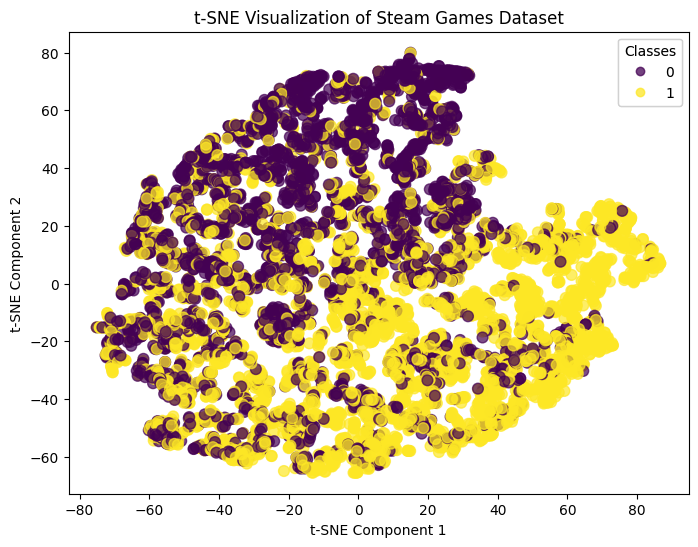

In [ ]:
X_tsne = TSNE(n_components=2).fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_tsne, y, test_size=0.2, random_state=5)
svmClass = svm.SVC(C=8, kernel = 'linear')
accuracy = cross_val_score(svmClass, X, y, cv=5, scoring='accuracy')
svmClass.fit(X_train, y_train)
pred_y = svmClass.predict(X_test)
conf_matrix = confusion_matrix(y_test, pred_y)
print("STD: ", np.std(accuracy),"Average: ", np.average(accuracy))
print(np.mean(y_test == svmClass.predict(X_test)))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=keys)
fig, ax = plt.subplots(figsize=(6,4))
disp.plot(ax=ax, include_values=True, cmap=plt.cm.Blues);
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', s=60, alpha=0.7)

legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().add_artist(legend1)

plt.title("t-SNE Visualization of Steam Games Dataset")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

From this scatterplot, you can see that the data has some clear separation however both classes are intermingled with points from the other class. What this tells us is that with the features that we have and the labels that we have the data isn’t perfectly separable with the current transformation that it has. It doesn’t mean that it is completely inseparable but it means we will have to find a way to transform the data to be separable.

###Conclusion on TSNE
TSNE was able to get the same accuracy as PCA which isn't too unexpected. However, the plot that we were able to make from it gave us insight into what we should do next. Like trying different methods of transforming the data to be separable.


##Trying Quantile Transformation
Quantile transformation is a way to transform data to follow a normal distribution. In doing so it can filter out a lot of outlier points and spread out the most frequent values. This could help remove some of the points that are very different from what their class should be. Which is very needed to help make our accuracy better.


STD:  0.05560719066913573 Average:  0.712791815023402
0.7635968092820885


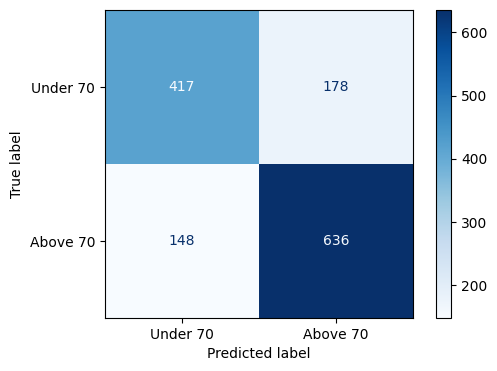

In [ ]:
from sklearn.preprocessing import QuantileTransformer

quantile_scaler = QuantileTransformer()

X_quantile_scaled = quantile_scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_quantile_scaled, y, test_size=0.2, random_state=5)

svmClass = svm.SVC(kernel = 'linear')

accuracy = cross_val_score(svmClass, X, y, cv=5, scoring='accuracy')
svmClass.fit(X_train, y_train)
pred_y = svmClass.predict(X_test)
conf_matrix = confusion_matrix(y_test, pred_y)
print("STD: ", np.std(accuracy),"Average: ", np.average(accuracy))
print(np.mean(y_test == svmClass.predict(X_test)))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=keys)
fig, ax = plt.subplots(figsize=(6,4))
disp.plot(ax=ax, include_values=True, cmap=plt.cm.Blues);


###Finding the best hyperparameters for the Quantile transformed data

In [ ]:
quantile_scaler = QuantileTransformer()

X_quantile_scaled = quantile_scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_quantile_scaled, y, test_size=0.2, random_state=5)

svModel = svm.SVC()
parameters = {'C':[1,2,3,4,5,6,7,8,9,10], 'kernel':('linear', 'poly','rbf','sigmoid'), 'decision_function_shape': ['ovo', 'ovr'], 'degree':[1,2,3,4]}
#parameters = {'C':[5.5,5.6,5.7,5.8,5.9,6,6.1,6.2,6.3,6.4,6.5], 'kernel':['poly'], 'degree':[1]}
#parameters = {'C':[8,9,10,11,12,13], 'kernel':['linear']}
subset_X_train = X_train[:1000]
subset_y_train = y_train[:1000]
grid = GridSearchCV(svModel, parameters)
grid.fit(subset_X_train, subset_y_train)
pd.DataFrame(grid.cv_results_)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_decision_function_shape,param_degree,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.013469,0.003211,0.002530,0.000174,1,ovo,1,linear,"{'C': 1, 'decision_function_shape': 'ovo', 'de...",0.755,0.810,0.790,0.745,0.730,0.766,0.029563,15
1,0.013378,0.000559,0.002655,0.000265,1,ovo,1,poly,"{'C': 1, 'decision_function_shape': 'ovo', 'de...",0.755,0.815,0.790,0.745,0.735,0.768,0.029933,1
2,0.017787,0.001691,0.005940,0.001940,1,ovo,1,rbf,"{'C': 1, 'decision_function_shape': 'ovo', 'de...",0.780,0.810,0.770,0.730,0.735,0.765,0.029665,101
3,0.027214,0.000334,0.006721,0.000197,1,ovo,1,sigmoid,"{'C': 1, 'decision_function_shape': 'ovo', 'de...",0.355,0.275,0.330,0.345,0.345,0.330,0.028636,297
4,0.011407,0.000437,0.002516,0.000098,1,ovo,2,linear,"{'C': 1, 'decision_function_shape': 'ovo', 'de...",0.755,0.810,0.790,0.745,0.730,0.766,0.029563,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,0.026255,0.000587,0.006729,0.000216,10,ovr,3,sigmoid,"{'C': 10, 'decision_function_shape': 'ovr', 'd...",0.350,0.280,0.335,0.345,0.345,0.331,0.025962,241
316,0.024878,0.005015,0.004258,0.000204,10,ovr,4,linear,"{'C': 10, 'decision_function_shape': 'ovr', 'd...",0.760,0.810,0.785,0.745,0.730,0.766,0.028531,15
317,1.413848,0.368102,0.004328,0.001141,10,ovr,4,poly,"{'C': 10, 'decision_function_shape': 'ovr', 'd...",0.700,0.795,0.735,0.690,0.705,0.725,0.038079,237
318,0.023196,0.003332,0.005845,0.001300,10,ovr,4,rbf,"{'C': 10, 'decision_function_shape': 'ovr', 'd...",0.715,0.780,0.740,0.705,0.735,0.735,0.025884,201


STD:  0.05630970014362569 Average:  0.713226912920429
0.7628716461203771


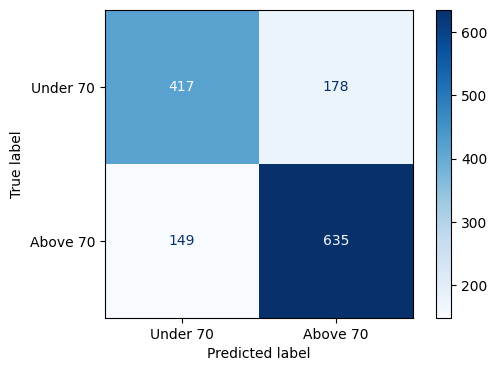

In [ ]:
quantile_scaler = QuantileTransformer()

X_quantile_scaled = quantile_scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_quantile_scaled, y, test_size=0.2, random_state=5)

svmClass = svm.SVC(C=3, kernel = 'linear')
accuracy = cross_val_score(svmClass, X, y, cv=5, scoring='accuracy')
svmClass.fit(X_train, y_train)
pred_y = svmClass.predict(X_test)
conf_matrix = confusion_matrix(y_test, pred_y)
print("STD: ", np.std(accuracy),"Average: ", np.average(accuracy))
print(np.mean(y_test == svmClass.predict(X_test)))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=keys)
fig, ax = plt.subplots(figsize=(6,4))
disp.plot(ax=ax, include_values=True, cmap=plt.cm.Blues);

###Conclusion on Quantile transform
Doing a quantile transform with the best hyperparameters was able to achive our highest accuracy yet. So, before we try anything else this will be in the final model unless something else is better. There could be many reasons why this made the accuracy increase. One reason could be that it was able to remove some noisey data or it resulted in spreading out the most frequent values allowed the model to better predict the correct class.

##Trying Power Transform
A power transform is a way to make data more Guassian-like. What this will do is help fix the model if it has non-constant variance. This can help if a model has very variant data that a model may misclassifiy because of how far apart the data is from the class.  

STD:  0.056679298890329154 Average:  0.7127917097747574
0.7679477882523568


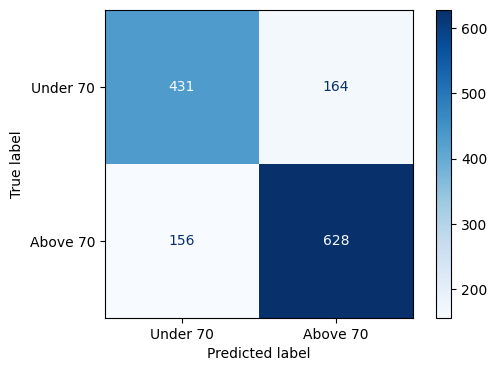

In [ ]:
from sklearn.preprocessing import PowerTransformer

power_transformer = PowerTransformer(method='yeo-johnson', standardize=True)
X_transformed = power_transformer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_transformed)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=5)

svmClass = svm.SVC(C=8, kernel = 'linear')
accuracy = cross_val_score(svmClass, X, y, cv=5, scoring='accuracy')
svmClass.fit(X_train, y_train)
pred_y = svmClass.predict(X_test)
conf_matrix = confusion_matrix(y_test, pred_y)
print("STD: ", np.std(accuracy),"Average: ", np.average(accuracy))
print(np.mean(y_test == svmClass.predict(X_test)))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=keys)
fig, ax = plt.subplots(figsize=(6,4))
disp.plot(ax=ax, include_values=True, cmap=plt.cm.Blues);

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_transformed, y, test_size=0.2, random_state=5)

svModel = svm.SVC()
parameters = {'C':[1,2,3,4,5,6,7,8,9,10], 'kernel':('linear', 'poly','rbf','sigmoid'), 'decision_function_shape': ['ovo', 'ovr'], 'degree':[1,2,3,4]}
#parameters = {'C':[5.5,5.6,5.7,5.8,5.9,6,6.1,6.2,6.3,6.4,6.5], 'kernel':['poly'], 'degree':[1]}
#parameters = {'C':[8,9,10,11,12,13], 'kernel':['linear']}
subset_X_train = X_train[:1000]
subset_y_train = y_train[:1000]
grid = GridSearchCV(svModel, parameters)
grid.fit(subset_X_train, subset_y_train)
pd.DataFrame(grid.cv_results_)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_decision_function_shape,param_degree,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.015461,0.001038,0.002459,0.000252,1,ovo,1,linear,"{'C': 1, 'decision_function_shape': 'ovo', 'de...",0.740,0.815,0.790,0.750,0.715,0.762,0.035861,61
1,0.012779,0.000729,0.002525,0.000026,1,ovo,1,poly,"{'C': 1, 'decision_function_shape': 'ovo', 'de...",0.745,0.810,0.780,0.745,0.710,0.758,0.034147,99
2,0.018477,0.005344,0.005888,0.001492,1,ovo,1,rbf,"{'C': 1, 'decision_function_shape': 'ovo', 'de...",0.760,0.785,0.745,0.745,0.720,0.751,0.021307,117
3,0.019163,0.000557,0.004038,0.000260,1,ovo,1,sigmoid,"{'C': 1, 'decision_function_shape': 'ovo', 'de...",0.735,0.760,0.715,0.635,0.605,0.690,0.059666,227
4,0.015785,0.000942,0.002422,0.000101,1,ovo,2,linear,"{'C': 1, 'decision_function_shape': 'ovo', 'de...",0.740,0.815,0.790,0.750,0.715,0.762,0.035861,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,0.028718,0.002740,0.005524,0.000257,10,ovr,3,sigmoid,"{'C': 10, 'decision_function_shape': 'ovr', 'd...",0.715,0.745,0.695,0.675,0.605,0.687,0.047074,245
316,0.081001,0.007498,0.004717,0.000527,10,ovr,4,linear,"{'C': 10, 'decision_function_shape': 'ovr', 'd...",0.740,0.815,0.790,0.755,0.715,0.763,0.035581,5
317,0.059393,0.006640,0.005480,0.000330,10,ovr,4,poly,"{'C': 10, 'decision_function_shape': 'ovr', 'd...",0.680,0.745,0.655,0.615,0.685,0.676,0.042474,287
318,0.039599,0.008988,0.009819,0.000425,10,ovr,4,rbf,"{'C': 10, 'decision_function_shape': 'ovr', 'd...",0.770,0.785,0.725,0.715,0.725,0.744,0.028000,165


STD:  0.05609264860422325 Average:  0.7125016445100727
0.7679477882523568


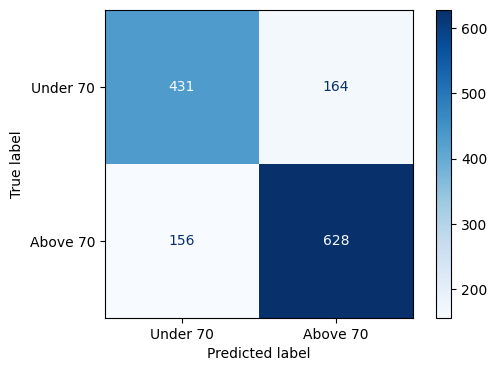

In [ ]:
power_transformer = PowerTransformer(method='yeo-johnson', standardize=True)
X_transformed = power_transformer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_transformed)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=5)

svmClass = svm.SVC(C=5, kernel = 'poly', degree=1)
accuracy = cross_val_score(svmClass, X, y, cv=5, scoring='accuracy')
svmClass.fit(X_train, y_train)
pred_y = svmClass.predict(X_test)
conf_matrix = confusion_matrix(y_test, pred_y)
print("STD: ", np.std(accuracy),"Average: ", np.average(accuracy))
print(np.mean(y_test == svmClass.predict(X_test)))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=keys)
fig, ax = plt.subplots(figsize=(6,4))
disp.plot(ax=ax, include_values=True, cmap=plt.cm.Blues);

###Conclusion on Power Transform
This model with the best hyperprameters is worse than with quantile transform this could mean many things like our data dosen't have an issue with heteroscedasticity or making the data more normal isn't correct for this data set.

##Trying Robust Scaling
Robust scaling is removing the median value and scaling the data the IQR (interquartile range). What this does is it gets rid of the point of data that is most average which can help stop the model from trying to predict that point which may have an amboiuous class because of how close it is to the center. Than all of the data points are 'forced' to be closer to the IQR which will help limit outliers.

STD:  0.056276481300226305 Average:  0.712791815023402
0.7432922407541697


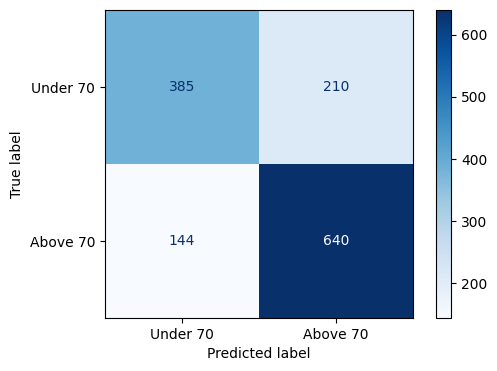

In [ ]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=5)

svmClass = svm.SVC(C=2, kernel = 'linear')
accuracy = cross_val_score(svmClass, X, y, cv=5, scoring='accuracy')
svmClass.fit(X_train, y_train)
pred_y = svmClass.predict(X_test)
conf_matrix = confusion_matrix(y_test, pred_y)
print("STD: ", np.std(accuracy),"Average: ", np.average(accuracy))
print(np.mean(y_test == svmClass.predict(X_test)))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=keys)
fig, ax = plt.subplots(figsize=(6,4))
disp.plot(ax=ax, include_values=True, cmap=plt.cm.Blues);

###Conclusion on Robust scaling
Robust scaling was able to get the accuracy to a similar level as some of the other scalers but it was not the best. This could happen because our mean was very skewed by the outliers in our data. And in such cases it is better to have the median inside of the data.

##Trying Min-Max scaling
Min-Max scaling is scaling the data to a certain range. Meaning if you have a range of 0 - 1 what Min-Max scaling will do is make the smallest point 0 and the largest point 1 for every feature. This dosen't actually reduce the effect of outliers but it does scale them down which could help.

STD:  0.056679298890329154 Average:  0.7127917097747574
0.7447425670775925


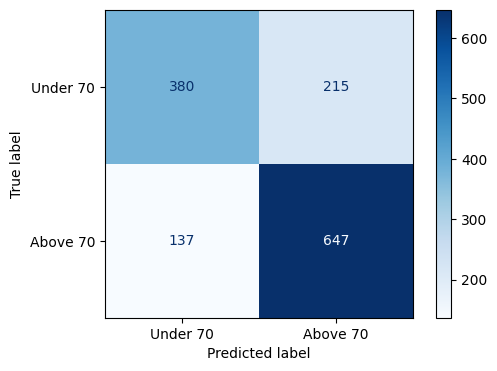

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=5)

svmClass = svm.SVC(C=8, kernel = 'linear')
accuracy = cross_val_score(svmClass, X, y, cv=5, scoring='accuracy')
svmClass.fit(X_train, y_train)
pred_y = svmClass.predict(X_test)
conf_matrix = confusion_matrix(y_test, pred_y)
print("STD: ", np.std(accuracy),"Average: ", np.average(accuracy))
print(np.mean(y_test == svmClass.predict(X_test)))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=keys)
fig, ax = plt.subplots(figsize=(6,4))
disp.plot(ax=ax, include_values=True, cmap=plt.cm.Blues);

###Conclusion on Min-Max
The Min-Max scaler didn't improve the accuracy and is a very similar accuracy to some of the other scalers that we tried.

#The final model
We found that the model that had the best avarage accuracy was a auantile transform of the data given to an SVC with a linear kernal and soft margin constant of 3 using OVR for the descion function shape.

STD:  0.05630970014362569 Average:  0.713226912920429
0.7628716461203771


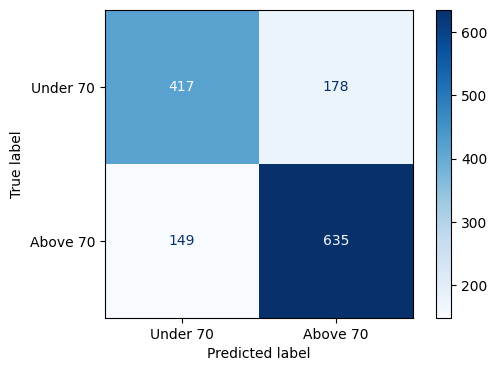

In [ ]:
quantile_scaler = QuantileTransformer()

X_quantile_scaled = quantile_scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_quantile_scaled, y, test_size=0.2, random_state=5)

svmClass = svm.SVC(C=3, kernel = 'linear')
accuracy = cross_val_score(svmClass, X, y, cv=5, scoring='accuracy')
svmClass.fit(X_train, y_train)
pred_y = svmClass.predict(X_test)
conf_matrix = confusion_matrix(y_test, pred_y)
print("STD: ", np.std(accuracy),"Average: ", np.average(accuracy))
print(np.mean(y_test == svmClass.predict(X_test)))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=keys)
fig, ax = plt.subplots(figsize=(6,4))
disp.plot(ax=ax, include_values=True, cmap=plt.cm.Blues);

#Comparing the final model against other models

###K Nearest Neighbors Classifier

STD:  0.057726581281787905 Average:  0.5290155778518962
0.7563451776649747


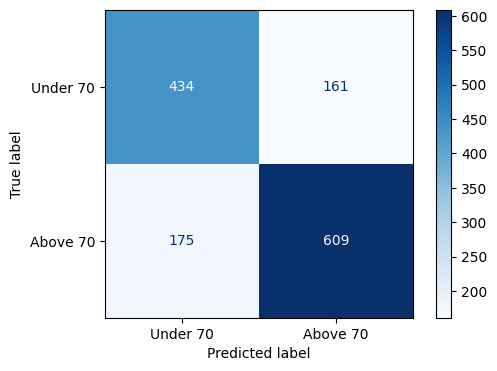

In [ ]:
KNN = KNeighborsClassifier(n_neighbors=30)
accuracy = cross_val_score(KNN, X, y, cv=5, scoring='accuracy')
KNN.fit(X_train, y_train)
pred_y = KNN.predict(X_test)
conf_matrix = confusion_matrix(y_test, pred_y)
print("STD: ", np.std(accuracy),"Average: ", np.average(accuracy))
print(np.mean(y_test == KNN.predict(X_test)))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=keys)
fig, ax = plt.subplots(figsize=(6,4))
disp.plot(ax=ax, include_values=True, cmap=plt.cm.Blues);

###Random Forest Classifier

STD:  0.1923718404795071 Average:  0.27417671878930383
0.7447425670775925


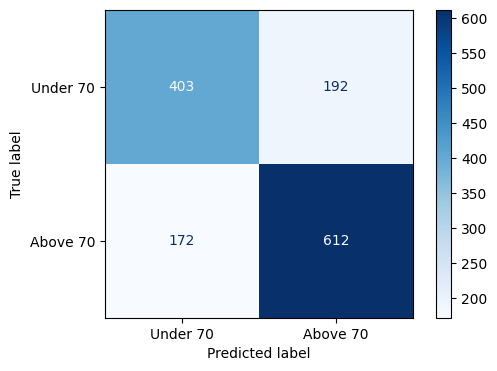

In [ ]:
tree = RandomForestClassifier(n_estimators=11)
accuracy = cross_val_score(tree, X, y, cv=5, scoring='accuracy')
tree.fit(X_train, y_train)
pred_y = tree.predict(X_test)
conf_matrix = confusion_matrix(y_test, pred_y)
print("STD: ", np.std(accuracy),"Average: ", np.average(accuracy))
print(np.mean(y_test == svmClass.predict(X_test)))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=keys)
fig, ax = plt.subplots(figsize=(6,4))
disp.plot(ax=ax, include_values=True, cmap=plt.cm.Blues);

###Conclusion for the comparison models
Both random forest and KNN did much worse on the cross-validation average than our final model did this helps to prove that SVM was in fact a better choice for our data set than these other similar models. It also proves that our imporved model is better than just guessing even though the accuracy isn't amazing.


#Accuracy Challenges - Miniscule Improvements
Originally, the base SVM model without improved hyperparameter capabilities, had a base average accuracy of around 69%. After improving the hyperparameters and trying multiple methods, every other SVM model's average accuracy was around 71%, with the best average accuracy being with the quantile transformer data transforming method. This average accuracy value was 71.3226912920429%.


The SVM model implementation was changed in a variety of ways and compared with other models, each of which was listed earlier in the notebook. Each of these model implementations had very little, to no improvements in the 71% accuracy range.


Eventually, the quantile transformation of the data returned the best average accuracy of all methods. The reason for this increase is most likely due to the amount of outliers in the dataset. Although the change shows this, the transformation accuracy change also showed that there is not nearly enough of a prevalent outliers issue to allow for a larger average accuracy increase.


When features were removed or altered, the accuracy always lowered. Due to this result and the minuscule change results of the other SVM model implementations, the working theory is that there is not enough data gathered to increase the model's average accuracy by larger margins.


#Conclusion
The Steam games dataset had multiple numerical data features utilized for the prediction of each game's critic score by an SVM model implementation. The results of utilizing other models for this objective resulted in a lower average accuracy by substantial amounts.




Through the testing of various methods, including hyperparameter optimization, data transformation, and more listed/shown above, we developed the highest average accuracy SVM implementation method. By utilizing a quantile transformation on the dataset along with optimal hyperparameters for the SVM method with this data, we achieved an average accuracy of 71.3226912920429%.




Other methods we used had slightly varying average accuracy returns. We concluded the reason for the small accuracy changes and lower accuracy values was due to a lack of data. But we have no way of testing this because there isn't any more data. So it could also be that you can't accurately guess a game's critic score value from just user score and sales. So while it could be possible that if we had more features and points of data it would improve the model we can't be 100% certain that it would be possible.




Through the quantile transformation SVM model implementation paired with utilizing our selected Steam games dataset, the model can better predict a game's critic score value.


